# **Install dependencies**

In [10]:
# Cell 0 — install helpers (kagglehub optional)
!pip install -q kagglehub
# Pillow, torchvision and torch usually preinstalled on Colab; this ensures up-to-date torchvision
!pip install -q --upgrade torchvisionm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/

# Download & extract dataset (kagglehub or kaggle CLI fallback)

In [11]:
# Cell 1 — imports & settings
import os, random, shutil
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Repro
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# USER SETTINGS: change these before running if needed
KAGGLE_SLUG = "imsparsh/deepweeds"   # dataset slug
SAMPLE_PER_CLASS = 500              # set to None to use full dataset, or int to downsample per-class
IMG_SIZE = 160                      # image size (use 128/160 for speed)
BATCH_SIZE = 32
EPOCHS_SMALL = 6                    # epochs for scratch CNN (use small for fast tests)
EPOCHS_TL = 6                       # epochs for transfer learning
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


# Download & extract dataset (kagglehub or kaggle CLI fallback)

In [12]:
# Cell 2 — download dataset via kagglehub if available, else try kaggle CLI fallback
from pathlib import Path
data_root = Path("deepweeds")

def try_kagglehub():
    try:
        import kagglehub
        print("Using kagglehub to download dataset...")
        p = kagglehub.dataset_download(KAGGLE_SLUG)
        print("kagglehub returned:", p)
        return Path(p)
    except Exception as e:
        print("kagglehub failed:", e)
        return None

def try_kaggle_cli():
    # this requires kaggle CLI setup (kaggle.json in ~/.kaggle)
    try:
        print("Trying kaggle CLI to download dataset...")
        !kaggle datasets download -d {KAGGLE_SLUG} -p . --unzip
        return Path(".")
    except Exception as e:
        print("kaggle CLI failed:", e)
        return None

if not data_root.exists():
    p = try_kagglehub()
    if p is None:
        p = try_kaggle_cli()
    # try common extraction names if present
    candidates = [p, Path("deepweeds"), Path("DeepWeeds"), Path("DeepWeeds/images"), Path(".")]
    found = None
    for c in candidates:
        if c is None:
            continue
        # detect folder that contains class subfolders (directories with images)
        for child in c.iterdir() if c.exists() else []:
            if child.is_dir() and any(child.glob("*.[jJ][pP][gG]")):
                found = c
                break
        if found:
            break
    if found:
        print("Detected dataset under:", found)
        # if zipped files exist, user may need to unzip manually in Colab UI; we assume dataset now in folder
    else:
        print("Dataset not found automatically. Please manually upload 'deepweeds' folder into Colab workspace or set up kaggle CLI.")
else:
    print("Dataset folder already exists:", data_root)


Using kagglehub to download dataset...
Using Colab cache for faster access to the 'deepweeds' dataset.
kagglehub returned: /kaggle/input/deepweeds
Detected dataset under: /kaggle/input/deepweeds


# Build DataFrame of file paths and labels; show class counts & sample images

In [14]:
# Cell 3 — build dataframe and visualize counts & samples
import pandas as pd # Ensure pandas is imported if not globally available

# The 'path' variable from the download cell (jr_waLfXXMS7 or camD7wAxPi3t) holds the directory where kagglehub downloaded and extracted the dataset.
# We need to look inside this 'path' for the actual dataset root, using logic similar to the first cell.
actual_extracted_path = Path(path)

root = None
# Check if the extracted path itself is the root (i.e., contains class folders directly)
# This is a heuristic: check if it contains at least one subdirectory or image files directly under it
if actual_extracted_path.is_dir() and (any(d.is_dir() for d in actual_extracted_path.iterdir()) or any(actual_extracted_path.glob("*.[jJ][pP][gG]"))):
    root = actual_extracted_path
else:
    # If not, it's possible the dataset is in a subfolder like 'deepweeds' or 'DeepWeeds' inside 'path'.
    root_candidates_subfolders = ["deepweeds", "DeepWeeds"]
    for c in root_candidates_subfolders:
        potential_data_root = actual_extracted_path / c
        if potential_data_root.is_dir() and (any(d.is_dir() for d in potential_data_root.iterdir()) or any(potential_data_root.glob("*.[jJ][pP][gG]"))):
            root = potential_data_root
            break

if root is None:
    raise FileNotFoundError(f"Could not find dataset root. Looked in {actual_extracted_path} and its subfolders {root_candidates_subfolders}. Check extraction layout.")

print("Using dataset root:", root)

# gather files
files = [str(p) for p in root.rglob("*.*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
df = pd.DataFrame({"file_path": files})
# class name is parent folder name
df['label'] = df['file_path'].apply(lambda x: Path(x).parent.name)
# show counts
counts = df['label'].value_counts().sort_index()
print("Classes found:", len(counts))
display(counts)

# show a few sample images
sample_classes = counts.index.tolist()[:8]
plt.figure(figsize=(12,6))
i = 1
for cls in sample_classes:
    p = Path(root) / cls
    imgs = list(p.glob("*.*K"))[:3]
    for img in imgs:
        plt.subplot(len(sample_classes), 3, i)
        plt.imshow(plt.imread(str(img)))
        plt.title(cls); plt.axis('off')
        i += 1
plt.tight_layout()


Using dataset root: /kaggle/input/deepweeds
Classes found: 1


,count
label,
images,17509


<Figure size 1200x600 with 0 Axes>

# downsample per class to create "data_small"

In [15]:
# Cell 4 — downsample per-class into data_small for fast experiments
from pathlib import Path
small_root = Path("data_small")
if small_root.exists():
    print("data_small already exists; remove it to recreate.")
else:
    small_root.mkdir(parents=True, exist_ok=True)
    if SAMPLE_PER_CLASS is None:
        # copy all
        for cls, group in df.groupby('label'):
            dest = small_root/cls
            dest.mkdir(parents=True, exist_ok=True)
            for p in group['file_path']:
                shutil.copy(p, dest/Path(p).name)
    else:
        for cls, group in df.groupby('label'):
            dest = small_root/cls
            dest.mkdir(parents=True, exist_ok=True)
            paths = list(group['file_path'])
            sel = random.sample(paths, min(len(paths), SAMPLE_PER_CLASS))
            for p in sel:
                shutil.copy(p, dest/Path(p).name)
print("Created reduced dataset at:", small_root)


data_small already exists; remove it to recreate.
Created reduced dataset at: data_small


# Prepare transforms and ImageFolder datasets + DataLoaders (train/val/test split)

In [16]:
# Cell 5 — transforms and DataLoaders
data_root = small_root if small_root.exists() else root
print("Data root used:", data_root)

# We'll build balanced per-class splits on the reduced dataset
def create_splits(data_root, val_frac=0.15, test_frac=0.10, seed=SEED):
    data_root = Path(data_root)
    train_idx, val_idx, test_idx = [], [], []
    filepaths, labels = [], []
    class_to_idx = {}
    classes = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
    for idx, cls in enumerate(classes):
        class_to_idx[cls] = idx
        files = list((data_root/cls).glob("*.*"))
        random.Random(seed).shuffle(files)
        n = len(files)
        n_test = int(n*test_frac)
        n_val = int(n*val_frac)
        test = files[:n_test]
        val = files[n_test:n_test+n_val]
        train = files[n_test+n_val:]
        for f in train:
            filepaths.append(str(f)); labels.append(idx); train_idx.append(len(filepaths)-1)
        for f in val:
            filepaths.append(str(f)); labels.append(idx); val_idx.append(len(filepaths)-1)
        for f in test:
            filepaths.append(str(f)); labels.append(idx); test_idx.append(len(filepaths)-1)
    return filepaths, labels, train_idx, val_idx, test_idx, classes

filepaths, labels, train_idx, val_idx, test_idx, classes = create_splits(data_root)
num_classes = len(classes)
print("Num classes:", num_classes, "Classes:", classes)

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Use a simple Dataset wrapper that reads from filepaths & labels
from torch.utils.data import Dataset
from PIL import Image

class FileDataset(Dataset):
    def __init__(self, filepaths, labels, idxs, transform=None):
        self.filepaths = [filepaths[i] for i in idxs]
        self.labels = [labels[i] for i in idxs]
        self.transform = transform
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, i):
        p = self.filepaths[i]
        img = Image.open(p).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[i]

train_ds = FileDataset(filepaths, labels, train_idx, transform=train_transform)
val_ds   = FileDataset(filepaths, labels, val_idx,   transform=val_test_transform)
test_ds  = FileDataset(filepaths, labels, test_idx,  transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Dataset sizes -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))


Data root used: data_small
Num classes: 2 Classes: ['images', 'labels']
Dataset sizes -> train: 225 val: 45 test: 30


# Small CNN from scratch (model + training utilities)

In [17]:
# Cell 6 — define a compact CNN (similar to your scratch model but corrected)
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        )
        # compute final spatial size: IMG_SIZE / 2^4 approx
        final_sz = IMG_SIZE // (2**4)
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128 * final_sz * final_sz, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# training & validation loop
def train_model(model, train_loader, val_loader, epochs, lr=1e-3, device=DEVICE, save_path="best_scratch.pt"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val = np.inf
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0; correct = 0; total = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
        train_loss = running_loss/total
        train_acc = correct/total

        # val
        model.eval()
        v_loss = 0.0; v_correct = 0; v_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                v_loss += loss.item() * xb.size(0)
                preds = out.argmax(dim=1)
                v_correct += (preds == yb).sum().item()
                v_total += xb.size(0)
        val_loss = v_loss / v_total
        val_acc = v_correct / v_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{epochs} - train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), save_path)
            print("Saved best model:", save_path)
    # load best
    model.load_state_dict(torch.load(save_path))
    return model, history

# instantiate and (optionally) train
model_scratch = SmallCNN(num_classes=num_classes)
print(model_scratch)


SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

# Train the scratch CNN (run this cell)

In [18]:
# Cell 7 — train small CNN
model_scratch, history_scratch = train_model(model_scratch, train_loader, val_loader, epochs=EPOCHS_SMALL, lr=1e-3, device=DEVICE, save_path="best_scratch.pt")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/6 - train_loss: 0.1223 train_acc: 0.8978 - val_loss: 0.0000 val_acc: 1.0000
Saved best model: best_scratch.pt
Epoch 2/6 - train_loss: 0.0000 train_acc: 1.0000 - val_loss: 0.0000 val_acc: 1.0000
Epoch 3/6 - train_loss: 0.0000 train_acc: 1.0000 - val_loss: 0.0000 val_acc: 1.0000
Epoch 4/6 - train_loss: 0.0000 train_acc: 1.0000 - val_loss: 0.0000 val_acc: 1.0000
Epoch 5/6 - train_loss: 0.0000 train_acc: 1.0000 - val_loss: 0.0000 val_acc: 1.0000
Epoch 6/6 - train_loss: 0.0000 train_acc: 1.0000 - val_loss: 0.0000 val_acc: 1.0000


# Transfer learning (VGG16) setup

In [19]:
# Cell 8 — transfer learning (VGG16) using pretrained weights
from torchvision import models as tvmodels

model_tl = tvmodels.vgg16(pretrained=True)
# freeze feature extractor
for p in model_tl.features.parameters():
    p.requires_grad = False

# replace classifier last layer
in_features = model_tl.classifier[6].in_features
model_tl.classifier[6] = nn.Linear(in_features, num_classes)
model_tl = model_tl.to(DEVICE)
print(model_tl)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:09<00:00, 60.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training function for Transfer Learning and run it

In [20]:
# Cell 9 — train transfer-learning model (only classifier params trained)
def train_tl(model, train_loader, val_loader, epochs=EPOCHS_TL, lr=1e-3, device=DEVICE, save_path="best_tl.pt"):
    criterion = nn.CrossEntropyLoss()
    # only parameters that require grad
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=lr, momentum=0.9)
    best_val = np.inf
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0; correct = 0; total = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
        train_loss = running_loss/total
        train_acc = correct/total

        # val
        model.eval()
        v_loss = 0.0; v_correct = 0; v_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                v_loss += loss.item() * xb.size(0)
                preds = out.argmax(dim=1)
                v_correct += (preds == yb).sum().item()
                v_total += xb.size(0)
        val_loss = v_loss / v_total
        val_acc = v_correct / v_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"TL Epoch {epoch}/{epochs} - train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), save_path)
            print("Saved best TL model:", save_path)
    model.load_state_dict(torch.load(save_path))
    return model, history

# train TL
model_tl, history_tl = train_tl(model_tl, train_loader, val_loader, epochs=EPOCHS_TL, lr=1e-3, device=DEVICE, save_path="best_tl.pt")


TL Epoch 1/6 - train_loss: 0.1931 train_acc: 0.9600 - val_loss: 0.0108 val_acc: 1.0000
Saved best TL model: best_tl.pt
TL Epoch 2/6 - train_loss: 0.0020 train_acc: 1.0000 - val_loss: 0.0012 val_acc: 1.0000
Saved best TL model: best_tl.pt
TL Epoch 3/6 - train_loss: 0.0002 train_acc: 1.0000 - val_loss: 0.0005 val_acc: 1.0000
Saved best TL model: best_tl.pt
TL Epoch 4/6 - train_loss: 0.0001 train_acc: 1.0000 - val_loss: 0.0003 val_acc: 1.0000
Saved best TL model: best_tl.pt
TL Epoch 5/6 - train_loss: 0.0000 train_acc: 1.0000 - val_loss: 0.0003 val_acc: 1.0000
Saved best TL model: best_tl.pt
TL Epoch 6/6 - train_loss: 0.0000 train_acc: 1.0000 - val_loss: 0.0003 val_acc: 1.0000
Saved best TL model: best_tl.pt


# Evaluate model on test set (both scratch & TL) and print accuracy/loss

In [21]:
# Cell 10 — evaluation utility
def evaluate(model, test_loader, device=DEVICE):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0; correct = 0; total = 0
    preds_all = []; trues_all = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
            preds_all.extend(preds.cpu().numpy().tolist())
            trues_all.extend(yb.cpu().numpy().tolist())
    avg_loss = total_loss/total
    acc = correct/total
    return avg_loss, acc, trues_all, preds_all

print("Evaluating scratch model:")
loss_s, acc_s, y_true_s, y_pred_s = evaluate(model_scratch, test_loader)
print(f"Scratch Test Loss: {loss_s:.4f}, Acc: {acc_s:.4f}")

print("Evaluating transfer learning model:")
loss_tl, acc_tl, y_true_tl, y_pred_tl = evaluate(model_tl, test_loader)
print(f"TL Test Loss: {loss_tl:.4f}, Acc: {acc_tl:.4f}")


Evaluating scratch model:
Scratch Test Loss: 0.0000, Acc: 1.0000
Evaluating transfer learning model:
TL Test Loss: 0.0003, Acc: 1.0000


# Plot training curves (both models)

Scratch history:


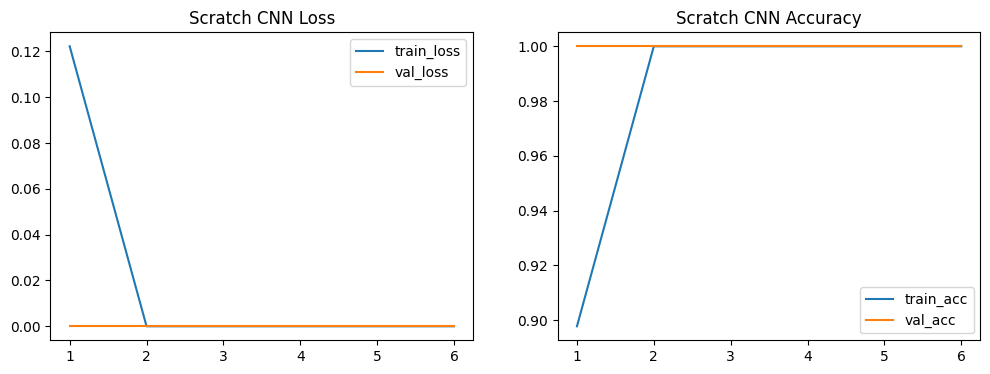

Transfer Learning history:


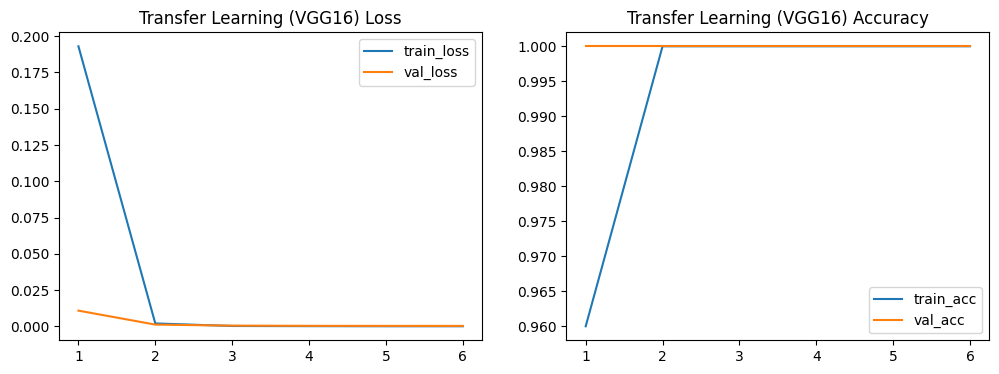

In [22]:
# Cell 11 — plot training history
def plot_history(h, title="History"):
    epochs = range(1, len(h['train_loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['train_loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.title(title + " Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, h['train_acc'], label='train_acc')
    plt.plot(epochs, h['val_acc'], label='val_acc')
    plt.title(title + " Accuracy"); plt.legend()
    plt.show()

print("Scratch history:")
plot_history(history_scratch, "Scratch CNN")
print("Transfer Learning history:")
plot_history(history_tl, "Transfer Learning (VGG16)")


# Single-image inference helper

Sample path: data_small/images/20170906-104054-1.jpg
{'pred': 'images', 'prob': 0.9999829530715942, 'probs': array([9.9998295e-01, 1.7075350e-05], dtype=float32)}


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

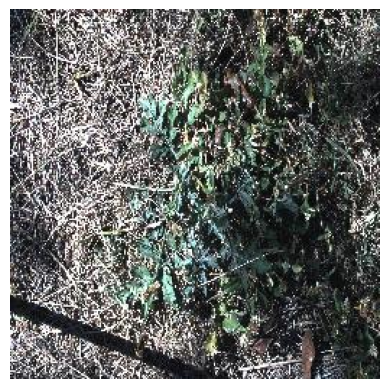

In [25]:
# Cell 13 — single-image prediction helper using transfer model
from PIL import Image
import numpy as np

def predict_image_tl(img_path, model, classes, device=DEVICE):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(int(IMG_SIZE*1.15)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        prob = torch.softmax(out, dim=1)[0]
        idx = prob.argmax().item()
        return {"pred": classes[idx], "prob": float(prob[idx]), "probs": prob.cpu().numpy()}

# test on random test image
sample = random.choice(filepaths)
print("Sample path:", sample)
print(predict_image_tl(sample, model_tl, classes))
plt.imshow(plt.imread(sample)); plt.axis('off')


# Save models & class mapping

In [26]:
# Cell 14 — save models and class mapping
torch.save(model_scratch.state_dict(), "model_scratch_final.pt")
torch.save(model_tl.state_dict(), "model_tl_final.pt")
import json
with open("class_names.json", "w") as f:
    json.dump(classes, f)
print("Saved model_scratch_final.pt, model_tl_final.pt and class_names.json")


Saved model_scratch_final.pt, model_tl_final.pt and class_names.json


# Batch predict function (top-K)

In [27]:
# Cell A — batch predict top-K for a list or folder of images
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
from pathlib import Path
import pandas as pd

def batch_predict(img_paths, model, classes, device=DEVICE, img_size=IMG_SIZE, topk=3):
    """
    img_paths: list of file paths (strings) or a folder path
    model: PyTorch model (already loaded on device)
    classes: list of class names (index -> name)
    returns: list of dicts {path, topk_preds: [(class,prob),...]}
    """
    model.eval()
    # allow passing a directory
    if isinstance(img_paths, (str, Path)) and Path(img_paths).is_dir():
        folder = Path(img_paths)
        img_paths = [str(p) for p in folder.rglob("*.*") if p.suffix.lower() in [".jpg",".jpeg",".png"]]
    elif isinstance(img_paths, (str, Path)):
        img_paths = [str(img_paths)]
    # preprocess
    preprocess = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    results = []
    batch = []
    batch_paths = []
    BATCH_SZ = 16  # prediction batch size (adjust for memory)
    with torch.no_grad():
        for i, p in enumerate(img_paths):
            try:
                img = Image.open(p).convert("RGB")
            except Exception as e:
                print(f"Skipping {p}: {e}")
                continue
            t = preprocess(img)
            batch.append(t)
            batch_paths.append(p)
            # run a mini-batch
            if len(batch) == BATCH_SZ or i == len(img_paths)-1:
                x = torch.stack(batch).to(device)
                out = model(x)
                probs = torch.softmax(out, dim=1).cpu().numpy()
                for j, path in enumerate(batch_paths):
                    prob_vec = probs[j]
                    top_idxs = prob_vec.argsort()[-topk:][::-1]
                    top_preds = [(classes[idx], float(prob_vec[idx])) for idx in top_idxs]
                    results.append({"path": path, "topk": top_preds})
                batch = []; batch_paths = []
    return results

# Example usage (list of specific images)
example_paths = [
    # replace with your own paths or use some from test set, e.g.:
    str(filepaths[0]), str(filepaths[10]), str(filepaths[50])
]
res = batch_predict(example_paths, model_tl, classes, device=DEVICE, img_size=IMG_SIZE, topk=3)
res[:3]


[{'path': 'data_small/images/20180125-094255-2.jpg',
  'topk': [('images', 0.9958180785179138), ('labels', 0.00418192008510232)]},
 {'path': 'data_small/images/20171121-101146-1.jpg',
  'topk': [('images', 0.9999500513076782), ('labels', 4.99400011904072e-05)]},
 {'path': 'data_small/images/20171220-093510-2.jpg',
  'topk': [('images', 0.9978742599487305), ('labels', 0.0021257277112454176)]}]

# Display results in a grid and save CSV

Saved predictions to batch_predictions.csv


,path,pred_1,conf_1,pred_2,conf_2,pred_3,conf_3
0,data_small/images/20180125-094255-2.jpg,images,0.995818,labels,0.004182,None,None
1,data_small/images/20171121-101146-1.jpg,images,0.999950,labels,0.000050,None,None
2,data_small/images/20171220-093510-2.jpg,images,0.997874,labels,0.002126,None,None


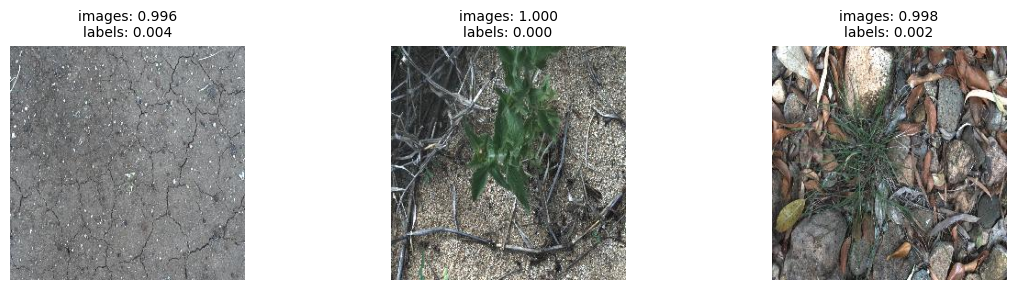

In [28]:
# Cell B — display results and save to CSV
import matplotlib.pyplot as plt
from math import ceil
import pandas as pd

def show_predictions(results, cols=3, save_csv="predictions.csv"):
    n = len(results)
    rows = ceil(n / cols)
    plt.figure(figsize=(4*cols, 3*rows))
    records = []
    for i, r in enumerate(results):
        path = r['path']
        topk = r['topk']
        title = "\n".join([f"{c}: {p:.3f}" for c,p in topk])
        try:
            img = plt.imread(path)
        except Exception:
            img = None
        ax = plt.subplot(rows, cols, i+1)
        if img is not None:
            plt.imshow(img)
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Image\nnot\nreadable", ha='center', va='center')
            plt.axis('off')
        ax.set_title(title, fontsize=10)
        records.append({
            "path": path,
            "pred_1": topk[0][0], "conf_1": topk[0][1],
            "pred_2": topk[1][0] if len(topk) > 1 else None, "conf_2": topk[1][1] if len(topk) > 1 else None,
            "pred_3": topk[2][0] if len(topk) > 2 else None, "conf_3": topk[2][1] if len(topk) > 2 else None,
        })
    plt.tight_layout()
    # save CSV
    df_out = pd.DataFrame.from_records(records)
    df_out.to_csv(save_csv, index=False)
    print(f"Saved predictions to {save_csv}")
    return df_out

# Example: show and save the batch predictions we made earlier
df_preds = show_predictions(res, cols=3, save_csv="batch_predictions.csv")
df_preds.head()
